# Objective of this project 
To simulate the Monte Carlo simulation for predicting future price paths of Tesla stock, I will follow these steps:

1. **Prepare the Historical Data**: Obtain historical data for Tesla stock from Yahoo Finance.

2. **Define Simulation Parameters**: Determine the parameters for the simulation, including the end date for the prediction (`pred_end_date`), the number of iterations for the simulation (`iterations`), and any other parameters.

3. **Calculate Log Returns**: Calculate the log returns from the historical adjust closing prices of Tesla stock. This involves taking the natural logarithm of the ratio of each day's adjust closing price to the previous day's closing price.

4. **Set Up Drift and Random Components**: Calculate the mean (drift) and standard deviation of the log returns. These parameters will be used to model the future returns of the asset.

5. **Generate Daily Returns**: Generate random daily returns using the normal distribution with the calculated mean and standard deviation. This generates a matrix of daily returns for each iteration and forecast date.

6. **Simulate Future Price Paths**: Simulate future price paths by compounding the daily returns over time. Starting from the last observed closing price in the historical data, apply the simulated daily returns to generate future price paths for each iteration.

7. **Analyze Results**: Analyze the simulated future price paths to gain insights into the range of potential outcomes and assess the uncertainty associated with future stock prices. You can calculate summary statistics, visualize the results, or perform further analysis as needed.



In [27]:
# getting historical data for Tesla. 
import numpy as np
np.random.seed(3363)
import pandas as pd

from scipy.stats import norm
import datetime 

import matplotlib.pyplot as plt
%matplotlib inline
ticker = "TSLA" #Tesla Stock

import yfinance as yf
df=yf.download(ticker, period='5y')

[*********************100%%**********************]  1 of 1 completed


In [28]:
df.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-22,140.559998,144.440002,138.800003,142.050003,142.050003,107097600
2024-04-23,143.330002,147.259995,141.110001,144.679993,144.679993,124545100
2024-04-24,162.839996,167.970001,157.509995,162.130005,162.130005,181178000
2024-04-25,158.960007,170.880005,158.360001,170.179993,170.179993,126427500
2024-04-26,168.850006,172.119995,166.369995,168.289993,168.289993,108896700


This data set includes historical price data for Tesla stock.

### Variables

- **Date**: The date corresponding to a specific trading day.
- **Open**: The opening price of the stock on a given trading day.
- **High**: The highest price of the stock on a given trading day.
- **Low**: The lowest price of the stock on a given trading day.
- **Close**: The closing price of the stock on a given trading day.
- **Adj Close**: The adjusted closing price of the stock, which accounts for splits in the stock price and other factors.
- **Volume**: The number of shares traded on a given trading day.ading day.

<Axes: title={'center': 'Price of TSLA from 2019-04-29 00:00:00 to 2024-04-26 00:00:00'}, xlabel='Date'>

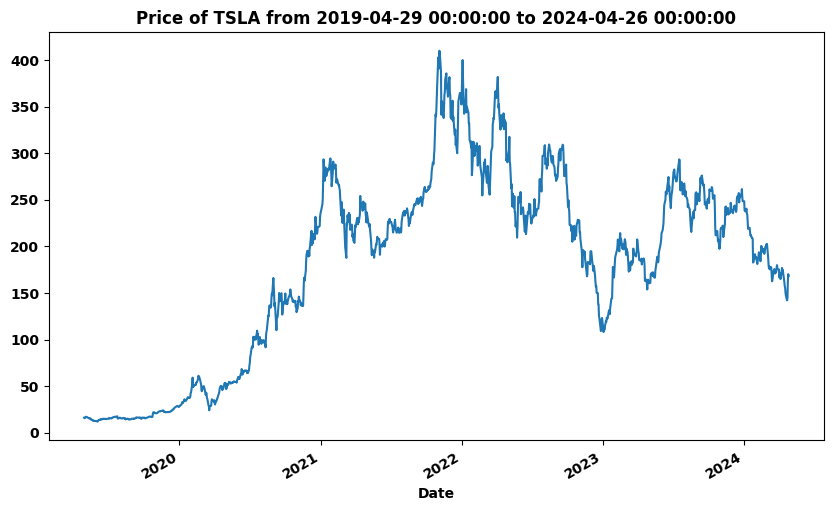

In [29]:
#Plot of asset historical closing price
df['Adj Close'].plot(figsize=(10, 6), title = "Price of {} from {} to {}".format(ticker, df.index.min(), df.index.max()))

# Monte Carlo Simulation

We need to set two parameters to run the simulation. One is the number of days we will predict into the future and the other is how many times we will simulate the future (100 simulations ). 

I assume the log of the returns (percent changes) are normally distributed and that the market is efficient. The formula for the change in price between periods is the price of the stock in t_0 multiplied by the expected drift (average change in price) plus an exogenous shock.

### Log Return Formula

The log return, also known as the logarithmic return or continuously compounded return, is calculated using the natural logarithm of the ratio of two prices. The formula for calculating log returns \( R \) between two prices \( P_1 \) and \( P_2 \) is:

$$ 
\text{Log Return} = \ln\left(\frac{P_2}{P_1}\right)
$$

Where- \( P_1 \) is the initial pric.
- \( P_2 \) is the final price.

The log return represents the continuously compounded rate of return between two prices. It is additive over time, making it convenient for financial modeling and analysis.

### Percentage Change Formula

The percentage change, often abbreviated as "pct_change," measures the relative change in a value between two periods, expressed as a percentage. The formula for calculating the percentage change between two values \( P_1 \) and \( P_2 \) is:

$$
\text{Percentage Change} = \frac{{P_2 - P_1}}{{P_1}} \times 100\
$$

Where:
- \( P_1 \) is th initial value.
- \( P_2 \) is the final value.

The percentage change indicates the magnitude and direction of change between two values. It is commonly used in financial analmanceysis to assess the perfor
When applied to a time series of asset prices, the percentage change between consecutive values indicates the relative price movement between those two time points. This information is valuable for investors, traders, and analysts to make informed decisions about buying, selling, or holding assets based ot.
nce of assets over time.




<div style="border: 1px solid black; padding: 10px;">
$$
\text{Log Return} = \ln(1 + \text{Percentage Change})
$$
</div>


### Drift Formula $$
drift = u - \frac{1}{2} \cdot var
$$

**Use of Drift:**

The drift term is a key component in modeling the expected rate of return of the asset.
It is used in combination with the standard deviation of the log returns (stdev) to define the parameters of a normal distribution.
These parameters are then used to generate random daily returns for the Monte Carlo simulation.

### Monte Carlo Simulations

$$
\text{Price}_i = \text{Price}_{i-1} \times e^{\text{drift} + \sigma \times Z }
$$


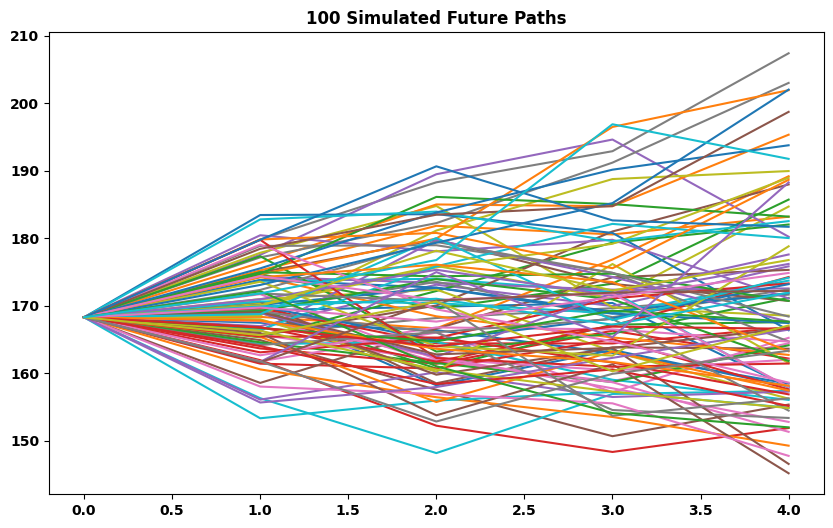

In [43]:
pred_end_date = datetime.datetime(2024, 4, 30)

def monte_carlo(pred_end_date, df=df, iterations=100, plot=True):
    pred_end_date = pred_end_date
    forecast_dates = [d if d.isoweekday() in range(1, 6) else np.nan for d in pd.date_range(df.index.max(), pred_end_date)] #For each date, it checks if the day of the week (retrieved using isoweekday())
                                                            # falls within the range from 1 to 5 (inclusive), indicating a weekday (Monday to Friday).
                                                                                                                            #If the date is a weekday, it is included in the forecast dates list as is.
                                                                                                                            #If the date is not a weekday (i.e., it falls on a weekend), np.nan (NumPy's representation of "Not a Number") is included instead.
    intervals = len(forecast_dates)
    iterations = iterations
    #Preparing log returns from data
    log_returns = np.log(1 + df['Adj Close'].pct_change())

    #Setting up drift and random component in relation to asset data
    u = log_returns.mean()
    var = log_returns.var()
    drift = u - (0.5 * var)
    stdev = log_returns.std()
    daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(intervals, iterations)))

    #Takes last data point as startpoint point for simulation

    price_list = np.zeros_like(daily_returns)
    price_list[0] = df['Adj Close'].values[-1]
    #Applies Monte Carlo simulation in asset
    for t in range(1, intervals):
        price_list[t] = price_list[t - 1] * daily_returns[t]

    forecast_df = pd.DataFrame(price_list)
    
    if plot: 
        forecast_df.plot(figsize=(10,6), legend=False, title = "{} Simulated Future Paths".format(iterations))
    
    end_values_df = forecast_df.tail(1)
    
    return forecast_df, end_values_df

forecast_df, end_values_df = monte_carlo(pred_end_date)

**The x-axis values  range from 0.0 (Friday April 26, 2024) to 4.0 (Tuesday April 30, 2024). Each integer value on the x-axis represents one day into the future.** 

Each of these paths represents a possible trajectory for the future price of the asset based on the random variations in daily returns simulated by the Monte Carlo method. The simulation generates these paths by compounding the random daily returns over time, starting from the last observed price in the historical data.

Even though weekends (Saturday (1)and Sunday (2) ) are typically excluded from financial market trading, the simulation includes them because it's modeling the potential future paths of the asset's price, irrespective of whether it's a trading day or not.

In financial modeling and simulation, it's common to include weekends and holidays in the simulation to capture all possible scenarios and maintain continuity in the time series data. However, in real-world trading, prices are not updated during weekends and holidays, but the simulation aims to project possible price movements regardless of trading hours.

In [23]:
forecast_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,168.289993,168.289993,168.289993,168.289993,168.289993,168.289993,168.289993,168.289993,168.289993,168.289993,...,168.289993,168.289993,168.289993,168.289993,168.289993,168.289993,168.289993,168.289993,168.289993,168.289993
1,176.863325,170.554337,165.038878,159.904885,165.047118,182.404156,166.346874,152.404555,179.326186,167.938009,...,181.720640,161.214116,161.093049,166.006350,165.012122,155.224160,165.252047,173.182971,165.065112,167.036666
2,177.441738,171.806046,165.383886,162.701596,153.817319,180.850846,163.165466,157.795331,181.792281,180.980959,...,177.260679,168.150347,156.396911,157.117814,157.346320,166.134930,178.101303,171.041795,158.118223,169.086294
3,192.327027,176.171105,164.995243,165.153244,159.799563,175.685816,165.716208,151.451679,186.753234,173.496193,...,174.442687,180.233446,162.850387,152.433343,149.492208,170.104827,181.225413,175.428876,158.724068,164.903968
4,202.943631,182.023476,164.197869,157.807336,172.085597,166.404321,157.554999,154.145539,191.875937,175.232950,...,177.224470,167.626822,164.195951,155.241648,149.779344,168.120475,181.844432,198.171410,156.335086,166.264370


**In this DataFrame:**

Each row represents a different forecast date.
Each column represents a different simulation iteration.
The values represent the simulated prices of Tesla stock for each forecast date and iteration.


For example:

* In the first row, all the values are the same (168.289993) which remains constant across all simulations as it serves as the starting point for each path.


* In subsequent rows, you see different values as the simulation progresses to future forecast dates. Each column represents a different simulation iteration, and the values in each row indicate the simulated prices for that particular iteration at the corresponding forecast date.
* the last row "end_values_df"  The predicted end values (final prices) of Tesla stock after the simulation period .

# Histogram of final predicted values

The simulated future paths graph is very hard to read. I’m interested in what the price will be on April 30, 2024. So I want to look at the predicted values for that day only and see the distribution of those values.

I assume the values are normally distributed because of the randomness in the Monte Carlo process.

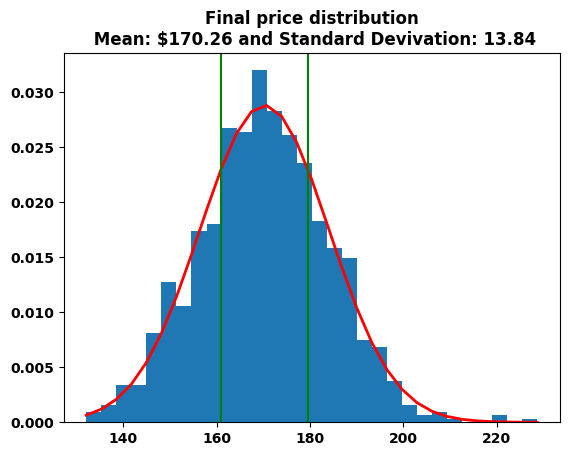

In [15]:
def plot_norm_hist(s, vline = True, title= True):
    mu, sigma = np.mean(s), np.std(s) # mean and standard deviation

    count, bins, ignored = plt.hist(s, 30, density=True)
    plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
    
    if vline:
        lline = -.67*sigma + mu
        uline = .67*sigma + mu
        plt.axvline(lline, color='g')
        plt.axvline(uline, color='g')

    if title:
        plt.title("Final price distribution\n Mean: ${:.02f} and Standard Devivation: {:.02f}".format(mu, sigma))
    
    return plt.show()
        
s = end_values_df.iloc[-1]
plot_norm_hist(s, vline=True, title=True)

The average final price is estimated to be around  170.26 . Additionally, the variability or spread of the final prices around this average is approximately 13.84. This implies that most of the final prices are expected to fall within a range of 170.26 ± 13.84   ( [156,41,184,09] )

# Partial Conclusion 
In conclusion, the Monte Carlo simulation provides us with a range of potential future price paths for the Tesla stock. By simulating multiple scenarios based on historical data and assumptions about future returns, we can gain insights into the potential outcomes and assess the associated uncertainty.

The distribution of final prices from the simulation indicates that the average final price is estimated to be aroun $170.26, with a variability or spread of approximately $13.84. This suggests that while the average outcome may be around $170.26, there is a degree of uncertainty, and actual final prices could vary around this averageons.

# The real price 
Here are the real values of the Tesla Stocks for April 30 ,2024

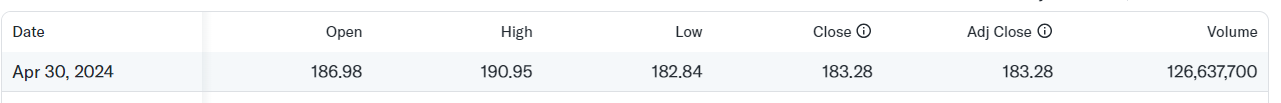

We can conclude that the observed adjusted close price of 183.28 falls within the simulated one .


 # Final Conclusion 
 The predictions from the Monte Carlo simulation were reasonably accurate, as the actual price fell within the simulated range.

Overall, the Monte Carlo simulation serves as a valuable tool for risk assessment and decision-making in financial analysis and investment strategy development. It allows us to quantify uncertainty, explore different scenarios, and make more informed decisions in the face of uncertain future market conditions.


# References :
Reasearch Paper: https://www.researchgate.net/publication/358954203_Monte_Carlo_Simulation_Prediction_of_Stock_Prices


